In [1]:
import os
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from sklearn.preprocessing import MinMaxScaler

In [2]:
# IBL data (16 Sessions, July 8)
# feature indices
lab_offset = 1
session_offset = 5
xyz_offset = 9
max_ptp_offset = 12
wf_width_offset = 13
left_dlc_offset = 14
right_dlc_offset = 28
stimOnOff_offset = 42
contrast_offset = 43
goCue_offset = 45
choice_offset = 46
reward_offset = 49
wheel_offset = 51
pLeft_offset = 52
lick_offset = 53
acronym_offset = 54

# Loader params
TEST_BATCH_SIZE = 5

In [3]:
# Load data
data = {}
j = 1
directory = '/Users/ksaniee/Downloads/original_feature_list_Sebastian' #location of original_feature_list_Sebastian
for filename in os.listdir(directory):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        data['output_%d'%j] = np.load(directory+'/'+'output_'+session)
        data['feature_%d'%j] = np.load(directory+'/'+'feature_'+session)
        j+=1
    

In [4]:
for filename in os.listdir(directory):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        file = np.load(directory+'/'+'output_'+session)
        print('session %s: length %d'% (filename[filename.find('_')+1:filename.find('.')],file.shape[1]) )

session dac3a4c1-b666-4de0-87e8-8c514483cacf: length 432
session 746d1902-fa59-4cab-b0aa-013be36060d5: length 575
session 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b: length 694
session ecb5520d-1358-434c-95ec-93687ecd1396: length 426
session 6f09ba7e-e3ce-44b0-932b-c003fb44fb89: length 326
session f312aaec-3b6f-44b3-86b4-3a0c119c0438: length 553
session ee40aece-cffd-4edb-a4b6-155f158c666a: length 966
session 56b57c38-2699-4091-90a8-aba35103155e: length 517
session c4432264-e1ae-446f-8a07-6280abade813: length 778
session 54238fd6-d2d0-4408-b1a9-d19d24fd29ce: length 541
session e535fb62-e245-4a48-b119-88ce62a6fe67: length 342
session 3638d102-e8b6-4230-8742-e548cd87a949: length 435
session d0ea3148-948d-4817-94f8-dcaf2342bbbe: length 441
session db4df448-e449-4a6f-a0e7-288711e7a75a: length 312
session d23a44ef-1402-4ed7-97f5-47e9a7a504d9: length 329
session dda5fc59-f09a-4256-9fb5-66c67667a466: length 704


In [5]:
# Reshape all clusters to single dimension
for j in range(1,17):
    data['output_'+str(j)]=data['output_'+str(j)].transpose((1,0,2)).reshape((-1,15*44))

In [6]:
# Decision data
for j in range(1,17):
    data['decision_'+str(j)]=data['feature_'+str(j)][:,:,:,46:49].sum(2)[0,:,:]

In [7]:
# One-hot encode no choice
for j in range(1,17):
    data['decision_'+str(j)]=np.apply_along_axis(lambda x: [0.,1.,0.] if sum(x)==0 else x,1,data['decision_'+str(j)])

In [8]:
# Normalize firing rates to clusters
for s in range(1,17):
    firing_rate = data['output_'+str(s)]
    for k in range(15):
        firing_rate[:,k*44:44*(k+1)] = (firing_rate[:,k*44:44*(k+1)]-firing_rate[:,k*44:44*(k+1)].mean())/firing_rate[:,k*44:44*(k+1)].std()
    data['output_'+str(s)] = firing_rate

In [9]:
# Reshape all neural activity to sequence per cluster
for j in range(1,17):
    data['output_'+str(j)]=data['output_'+str(j)].reshape((-1,15,44)).transpose((0,2,1))

In [10]:
# percent of L/R/'no choices' per session
for s in range(1,17):
    print('session %d  L: %f,R: %f,no: %f'%(s,
        (data['decision_%d'%s].sum(0)[0]/data['decision_%d'%s].shape[0]),
         (data['decision_%d'%s].sum(0)[2]/data['decision_%d'%s].shape[0]),
        (data['decision_%d'%s].sum(0)[1]/data['decision_%d'%s].shape[0])))

session 1  L: 0.590278,R: 0.409722,no: 0.000000
session 2  L: 0.613913,R: 0.386087,no: 0.000000
session 3  L: 0.299712,R: 0.700288,no: 0.000000
session 4  L: 0.476526,R: 0.523474,no: 0.000000
session 5  L: 0.334356,R: 0.665644,no: 0.000000
session 6  L: 0.490054,R: 0.509946,no: 0.000000
session 7  L: 0.422360,R: 0.577640,no: 0.000000
session 8  L: 0.442940,R: 0.557060,no: 0.000000
session 9  L: 0.411311,R: 0.588689,no: 0.000000
session 10  L: 0.497227,R: 0.502773,no: 0.000000
session 11  L: 0.473684,R: 0.526316,no: 0.000000
session 12  L: 0.581609,R: 0.418391,no: 0.000000
session 13  L: 0.632653,R: 0.367347,no: 0.000000
session 14  L: 0.403846,R: 0.596154,no: 0.000000
session 15  L: 0.772036,R: 0.227964,no: 0.000000
session 16  L: 0.383523,R: 0.616477,no: 0.000000


In [11]:
# delete middle column of choice vector (since they are all 0)
for j in range(1,17):
    data['decision_'+str(j)]=data['decision_'+str(j)][:,[0,2]]

In [12]:
class LSTM(nn.Module):

    def __init__(self, out_dim, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, out_dim)
        #self.fc0 = nn.Linear(input_size, 4)

    def forward(self, x):
        h_0 = nn.Parameter(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = nn.Parameter(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        
        #x = self.fc0(x)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [13]:
# return batches of sequences for LSTM input; X and Y are trial matrices (see below cell)
def sliding_windows(X,Y,seq_length):
    x = []
    y = []

    for i in range(X.shape[0]-seq_length-1):
        _x = X[i:(i+seq_length)]
        _y = Y[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


In [14]:
# Session 1, trial 1 data
# X: 44 time bins x 15 clusters
# Y: 44 time bins x 8-dim paw DLC positions (Left/Right, x/y, camera 1/2)
Y = data['feature_1'][1,1,:,:][:,[24,25,26,27,38,39,40,41]]
X = data['output_1'][1,:,:]

X.shape, Y.shape

((44, 15), (44, 8))

In [15]:
# Session length and train/test lengths for Sessions 1 & 2
num_trials2 = data['feature_2'].shape[1]
n_train_trials2 = int(np.floor(0.8*num_trials2))
n_test_trials2 = num_trials2-n_train_trials2
num_trials = data['feature_1'].shape[1]
n_train_trials = int(np.floor(0.8*432))
n_test_trials = num_trials-n_train_trials

In [16]:
#Session 1 sequence batches

seq_length=4

inXs, Ys = [],[]   # sequencified datasets for each trial
for t in range(num_trials):
    Yt = data['feature_1'][1,t,:,:][:,[24,25,26,27,38,39,40,41]]
    Xt = data['output_1'][t,:,:]
    xt, yt = sliding_windows(Xt,Yt, seq_length)
    inXt = torch.Tensor(np.array(xt))
    Yt = torch.Tensor(np.array(yt))
    inXs.append(inXt)
    Ys.append(Yt)

In [17]:
#Session 2 
inXs2, Ys2 = [],[]   # sequenced datasets for each trial
for t in range(num_trials2):
    Yt = data['feature_2'][1,t,:,:][:,[24,25,26,27,38,39,40,41]]
    Xt = data['output_2'][t,:,:]
    xt, yt = sliding_windows(Xt,Yt, seq_length)
    inXt = torch.Tensor(np.array(xt))
    Yt = torch.Tensor(np.array(yt))
    inXs2.append(inXt)
    Ys2.append(Yt)

In [18]:
inXs[0].shape,Ys[0].shape

(torch.Size([39, 4, 15]), torch.Size([39, 8]))

In [19]:
num_epochs = 1000

input_size = 15
hidden_size = 80
num_layers = 1
out_dim = 8

lstm = LSTM(out_dim, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters())

# Train the model
for epoch in range(num_epochs):
    
    session_loss=0 #track loss summed over all trials in session
    
    # "Minibatch" gradient descent batches over 10 trials (this helped)
    for t in range(n_train_trials//10):
        loss=0
        optimizer.zero_grad()
        for m in range(10):
            outputs = lstm(inXs[10*t+m])

            # obtain the loss function
            loss += criterion(outputs, Ys[10*t+m])

        loss.backward()
        optimizer.step()
        
        session_loss += loss.item()
    if epoch % 100 == 0: print("Epoch: %d, loss: %1.5f" % (epoch, session_loss))

Epoch: 0, loss: 101638.26953


In [ ]:
# Pretrain on Session 2

lstm2 = LSTM(out_dim, input_size, hidden_size, num_layers)

optimizer = torch.optim.Adam(lstm2.parameters())

# Train the model
for epoch in range(5000):
    session_loss=0
    for t in range(n_train_trials2//10):
        loss=0
        optimizer.zero_grad()
        for m in range(10):
            outputs = lstm2(inXs2[10*t+m])

            # obtain the loss function
            loss += criterion(outputs, Ys2[10*t+m])

        loss.backward()
        optimizer.step()
        
        session_loss += loss.item()
    if epoch % 100 == 0: print("Epoch: %d, loss: %1.5f" % (epoch, session_loss))
        
# Transfer to Session 1

#lstm.fc0 = nn.Linear(input_size,4)
lstm2.fc = nn.Linear(hidden_size,out_dim)
optimizer = torch.optim.Adam(lstm2.parameters())

print('\n Transferring to session 1 \n')

# Train the model
for epoch in range(10000):
    session_loss=0
    for t in range(n_train_trials//10):
        loss=0
        optimizer.zero_grad()
        for m in range(10):
            outputs = lstm2(inXs[10*t+m])

            # obtain the loss function
            loss += criterion(outputs, Ys[10*t+m])

        loss.backward()
        optimizer.step()
        
        session_loss += loss.item()
    if epoch % 100 == 0: print("Epoch: %d, loss: %1.5f" % (epoch, session_loss))

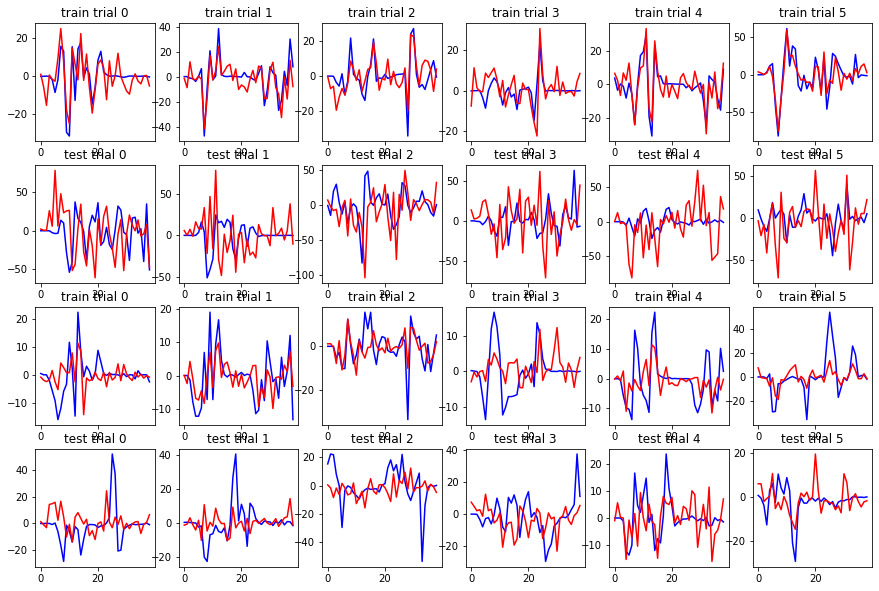

In [337]:
# Plot LSTM outputs on some train/test trials
some_train_trials = [1,10,50,100,150,300]
some_test_trials = [390,401,410,420,425,426]
plt.figure(figsize=(15,10))
for t in range(6):
    plt.subplot(4,6,t+1)
    plt.plot(Ys[some_train_trials[t]][:,1].detach().numpy(),c='blue')
    plt.plot(lstm(inXs[some_train_trials[t]])[:,1].detach().numpy(),c='red')
    plt.title('train trial %s'%t)
    plt.subplot(4,6,t+1+6)
    plt.plot(Ys[some_test_trials[t]][:,1].detach().numpy(),c='blue')
    plt.plot(lstm(inXs[some_test_trials[t]])[:,1].detach().numpy(),c='red')
    plt.title('test trial %s'%t)
    plt.subplot(4,6,t+1+12)
    plt.plot(Ys[some_train_trials[t]][:,-1].detach().numpy(),c='blue')
    plt.plot(lstm(inXs[some_train_trials[t]])[:,-1].detach().numpy(),c='red')
    plt.title('train trial %s'%t)
    plt.subplot(4,6,t+1+18)
    plt.plot(Ys[some_test_trials[t]][:,-1].detach().numpy(),c='blue')
    plt.plot(lstm(inXs[some_test_trials[t]])[:,-1].detach().numpy(),c='red')
    plt.title('test trial %s'%t)